In [1]:
imports_path = ".\\imports.ipynb"
tableGAN_path = ".\\tableGAN.ipynb"
utils_path = ".\\utils.ipynb"

%run "$imports_path"

In [2]:
%run "$utils_path"
%run "$tableGAN_path"
%load_ext line_profiler

In [3]:
n_epochs = 20
n_critic = 10
adam_lr = 0.0002
adam_beta1 = 0.5
model_dir = ".\\Model\\tableGAN_ckpt\\compare_adult\\"
noise_discrete_unif_max = 0

batch_size = 500
ckpt_every = 1
loss_plot_update_every = 10

image_dir = ".\\Images"
timer_dir = ".\\Timers"
dataset_dir = ".\\Datasets"
retrain = True

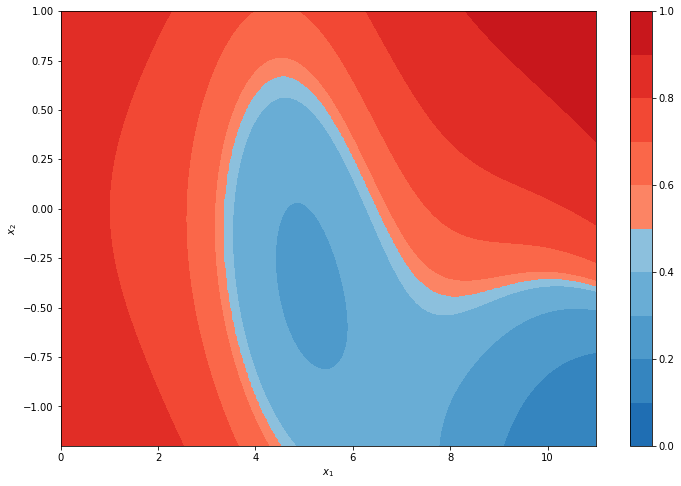

In [4]:
n_cols = 10
# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
colors1 = matplotlib.cm.get_cmap('Blues_r')(np.linspace(0.2, 0.6, n_cols))
colors2 = matplotlib.cm.get_cmap('Reds')(np.linspace(0.4, 0.8, n_cols))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
cmap_br = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

def classifier_func(x1, x2):
    a = 0.1 * (x1 - 5)**2 + (x2)**2 - 0.5 + 0.2 * tf.sqrt(x1) - 0.1*x1 + 0.005*x1**3 * x2 + 0.5*np.sin(x1) + 0.3*np.cos(x2)
    b = tf.sign(a) * (tf.abs(a))**(1/2)
    return(tf.math.sigmoid(b).numpy())


fig, ax = plt.subplots(figsize=[12,8])
def plot_heatmap(ax, heat_map_res = 200, incl_axis_labels = True, incl_colorbar = True, ret_contour = True):
    x1 = np.linspace(0, 11, heat_map_res)
    x2 = np.linspace(-1.2, 1, heat_map_res)
    x1_mesh, x2_mesh = np.meshgrid(x1, x2)
    
    y_mesh = classifier_func(x1_mesh, x2_mesh)
    cont1 = ax.contourf(x1_mesh, x2_mesh, y_mesh, levels = np.linspace(0, 1, n_cols + 1), cmap = cmap_br)
    if (incl_axis_labels):
        ax.set_xlabel(r"$x_1$")
        ax.set_ylabel(r"$x_2$")
    if incl_colorbar:
        plt.colorbar(cont1, ax = ax)
    if ret_contour:
        return cont1

plot_heatmap(ax)
plt.savefig(os.path.join(image_dir, "prediction_func_for_cf_testing.svg"))

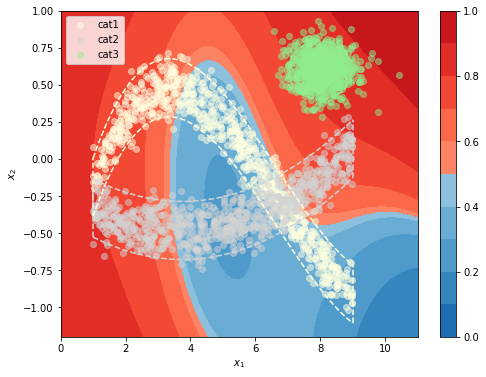

In [5]:
def classifier(data):
    return(classifier_func(data["x1"], data["x2"]))

n_train = 5000

x1_low, x1_high = 1,9
np.random.seed(1)

def sample_x1_given_x3(x3):
    x1_given_cat1_or_cat2 = np.random.uniform(x1_low, x1_high, n_train)
    x1_given_cat3 = np.random.normal(x1_mean_given_x3, sigma_x1 , n_train)
    return np.where(x3 == "cat3", x1_given_cat3, x1_given_cat1_or_cat2)

sigma_x2 = 0.1
sigma_x1 = 0.5
x3 = np.random.choice(["cat1","cat2", "cat3"], n_train)
x1_mean_given_x3 = 8
x2_mean_given_x3 = 0.6
x1 = sample_x1_given_x3(x3)

def mean_x2_given_x1_x3(x1, x3):
    cond_list = [x3 == "cat1", x3 == "cat2", x3 == "cat3"]
    choice_list = [0.01*(x1)**3 - 0.2*x1**2 + x1 - 1, 0.02*x1**2 - 0.15*x1 -0.2, x2_mean_given_x3]
    return np.select(cond_list, choice_list, default=0)

def sample_x2_given_x1_x3(x1,x3, sigma):
    return np.random.normal(mean_x2_given_x1_x3(x1, x3), sigma, n_train)

def conf_int_x2_given_x1_x3(x3, sigma_x1, sigma_x2, alpha = 0.05, n_steps = 100):
    if x3 == "cat1" or x3 == "cat2":
        x1 = np.linspace(x1_low, x1_high, n_steps)
        mean = mean_x2_given_x1_x3(x1, x3)
        return(x1, scipy.stats.norm.interval(1-alpha, loc=mean, scale=sigma_x2))
    elif x3 == "cat3":
        degree = np.linspace(0, np.pi, n_steps)
        x1 = x1_mean_given_x3 + np.cos(degree) * 1.96 *sigma_x1
        x2 = [x2_mean_given_x3 + np.sin(degree) * 1.96 * sigma_x2,
              x2_mean_given_x3 + np.sin(-degree) * 1.96 * sigma_x2]
        return x1, x2
    else:
        raise ValueError("The x3 paramter must be one of the values cat1, cat2 or cat3 and given in string format")

x2 = sample_x2_given_x1_x3(x1, x3, sigma_x2)
df_toy = pd.DataFrame({"x1" : x1, "x2" : x2, "x3" : x3})
df_toy.to_csv(os.path.join(dataset_dir, "df_toy.csv"), index=False)
category_colors = ["lightyellow", "lightgrey", "lightgreen"]

def plot_confint_x2_given_x1_and_x3(ax, sigma_x1, sigma_x2, alpha = 0.05):
    x1_grid, x2_confint = conf_int_x2_given_x1_x3("cat1", sigma_x1, sigma_x2, alpha =alpha)
    ax.plot(x1_grid, x2_confint[0], c= category_colors[0], linestyle = "dashed")
    ax.plot(x1_grid, x2_confint[1], c = category_colors[0], linestyle = "dashed")
    ax.plot([x1_grid[0], x1_grid[0]], [x2_confint[0][0], x2_confint[1][0]],
            c=category_colors[0], linestyle = "dashed")
    ax.plot([x1_grid[-1], x1_grid[-1]], [x2_confint[0][-1], x2_confint[1][-1]],
            c=category_colors[0], linestyle = "dashed")
    
    x1_grid, x2_confint = conf_int_x2_given_x1_x3("cat2", sigma_x1, sigma_x2, alpha = alpha)
    ax.plot(x1_grid, x2_confint[0], c= category_colors[1], linestyle = "dashed")
    ax.plot(x1_grid, x2_confint[1], c = category_colors[1], linestyle = "dashed")
    ax.plot([x1_grid[0], x1_grid[0]], [x2_confint[0][0], x2_confint[1][0]],
            c=category_colors[1], linestyle = "dashed")
    ax.plot([x1_grid[-1], x1_grid[-1]], [x2_confint[0][-1], x2_confint[1][-1]],
            c=category_colors[1], linestyle = "dashed")
    x1_grid, x2_confint = conf_int_x2_given_x1_x3("cat3", sigma_x1, sigma_x2, alpha=alpha)
    ax.plot(x1_grid, x2_confint[0], c=category_colors[2], linestyle="dashed")
    ax.plot(x1_grid, x2_confint[1], c=category_colors[2], linestyle="dashed")
    
    

fig, ax = plt.subplots(figsize=[8,6])
map_x3_to_col = lambda x3 : np.select([x3 == "cat1", x3 == "cat2", x3 == "cat3"], category_colors)
categories_unique = np.unique(df_toy["x3"])
plot_heatmap(ax)
for i, cat in enumerate(categories_unique):
    df_toy_subset = df_toy.loc[df_toy["x3"] == cat].head(750)
    plt.scatter(df_toy_subset["x1"], df_toy_subset["x2"], color = str(map_x3_to_col(cat)), alpha = 0.5, label = cat)
plot_confint_x2_given_x1_and_x3(ax, sigma_x1, sigma_x2)
plt.legend()
plt.savefig(os.path.join(image_dir, "Syn2D_cf.svg"), dpi=300)

In [187]:
%run "$tableGAN_path"
tg = TableGAN(df_toy, n_critic = n_critic, adam_lr = adam_lr, adam_beta1 = adam_beta1,
              quantile_transformation_int = False, quantile_rand_transformation = False,
             noise_discrete_unif_max = noise_discrete_unif_max)

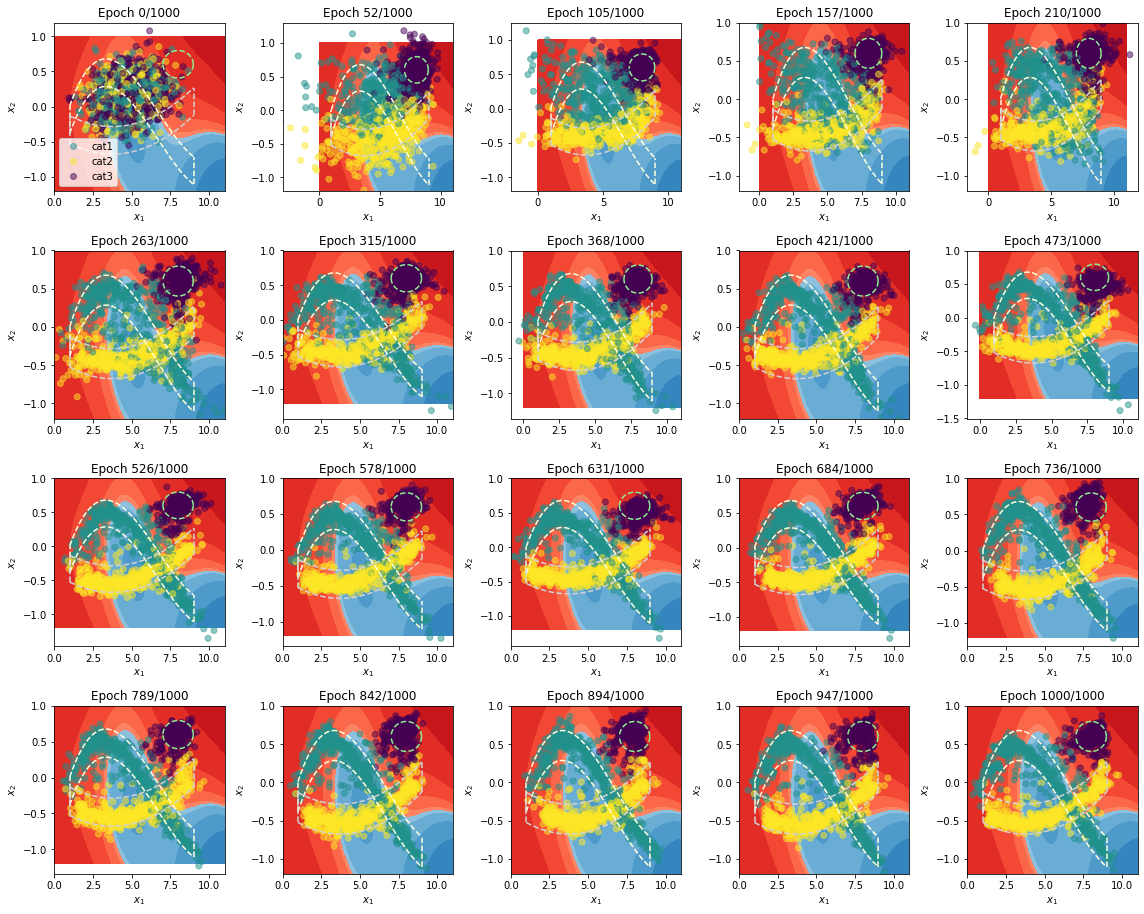

In [188]:
tg.train(n_epochs = 1000, batch_size = 500, restart_training = True, loss_plot_update_every = loss_plot_update_every,
             loss_plot_type = "line", progress_bar=True, plot2D_image = True, plot_loss = False, n_test=1500,
         plot2D_discrete_col="x3", save_dir = image_dir, filename_plot2D = "syn2D_cf_plot2D.svg",
         filename_train_loss = "syn2D_cf_train_loss.svg",
         plot2D_background_func = lambda ax : (plot_heatmap(ax, incl_colorbar = False, ret_contour = False),
                                               plot_confint_x2_given_x1_and_x3(ax, sigma_x1, sigma_x2)))

In [14]:
%lprun -f fast_non_dominated_sort a = tg.generate_counterfactuals(50, classifier, tg.data.loc[0], n_to_generate = 10000, add_plausibility_objective =True)

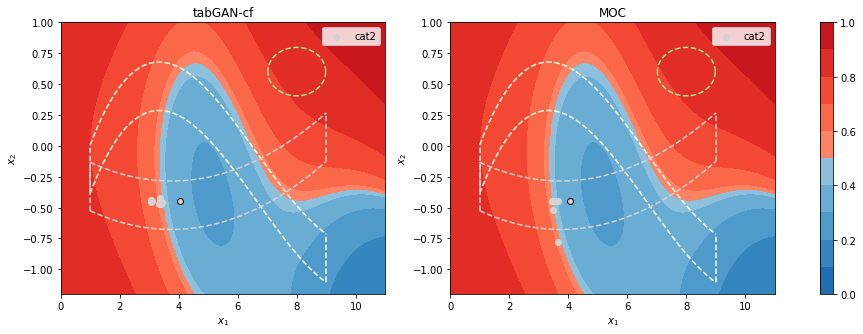

In [194]:
cf_dir = ".//Counterfactuals"
%run "$utils_path"
return_diff = False
compare_counterfactuals(df_toy, x_obs_nr = 89, save_path = "compare_counterfactuals_for_obs1.svg", save_dir=image_dir,
                       only_tabGAN_cf = False, figsize=[16,5])

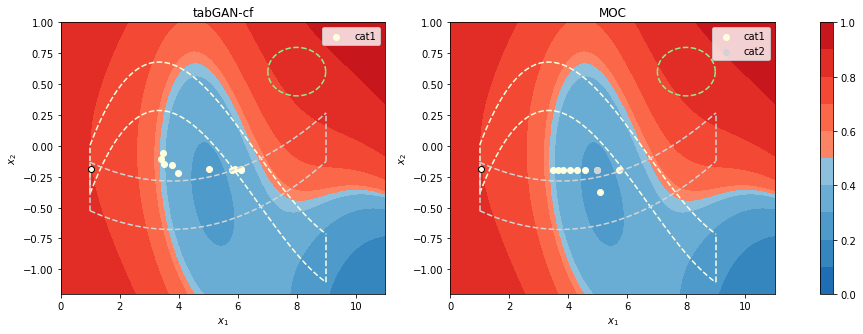

In [192]:
compare_counterfactuals(df_toy, x_obs_nr=243, save_path = "compare_counterfactuals_for_obs2.svg", save_dir=image_dir,
                       only_tabGAN_cf = False, figsize=[16,5])

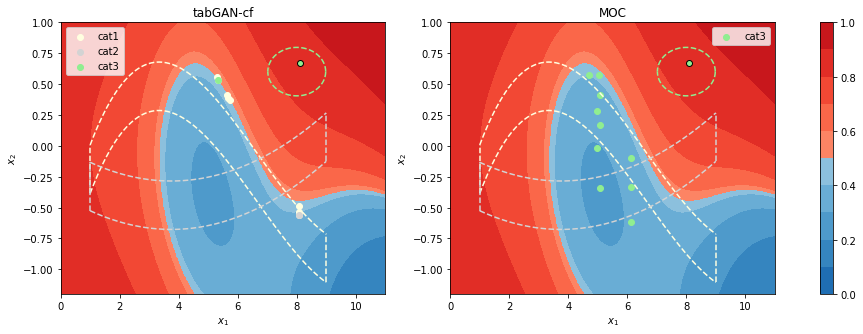

In [197]:
compare_counterfactuals(df_toy, x_obs_nr=11, save_path = "compare_counterfactuals_for_obs3.svg", save_dir=image_dir,
                       only_tabGAN_cf = False,figsize=[16,5])

In [102]:
print(df_toy.iloc[[89, 243, 11]].to_latex(index=False))

\begin{tabular}{rrl}
\toprule
      x1 &        x2 &   x3 \\
\midrule
4.049509 & -0.448952 & cat2 \\
1.038291 & -0.191824 & cat1 \\
8.107074 &  0.669967 & cat3 \\
\bottomrule
\end{tabular}



In [86]:
%run "$utils_path"
%run "$tableGAN_path"
data_adult_train= pd.read_csv('Datasets\\df_adult_edited_train.csv')
data_adult_test= pd.read_csv('Datasets\\df_adult_edited_test.csv')
discrete_columns = data_adult_train.columns[data_adult_train.dtypes == "object"]
data_adult_train[discrete_columns] = data_adult_train[discrete_columns].astype("category")
data_adult_test[discrete_columns] = data_adult_test[discrete_columns].astype("category")

data_adult_train_wo_income = data_adult_train.loc[:,data_adult_train.columns != "income"]

In [87]:
%run "$tableGAN_path"
tg_qt = TableGAN(data_adult_train_wo_income, n_critic = n_critic,
                 adam_lr = adam_lr, adam_beta1 = 0.5, adam_beta2 = 0.999,
              quantile_transformation_int = True, quantile_rand_transformation = False,
             noise_discrete_unif_max = noise_discrete_unif_max)

In [88]:
retrain = True
tic()
if retrain:
    tg_qt.train(n_epochs = 40, batch_size = 500, restart_training = True, loss_plot_update_every = loss_plot_update_every,
                 loss_plot_type = "line", progress_bar=True, plot_loss = False)
toc()

  0%|          | 0/40 [00:00<?, ?it/s]

Elapsed time: 212.471001 seconds.



In [89]:
clf = XGBClassifier(
        tree_method="gpu_hist", enable_categorical=True, use_label_encoder=True, eval_metric = "logloss"
    )

In [90]:
clf.fit(data_adult_train_wo_income, data_adult_train["income"])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=True,
              eval_metric='logloss', gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [91]:
accuracy = accuracy_score(data_adult_test["income"],
                          clf.predict(data_adult_test.loc[:,data_adult_test.columns != "income"]))
auc = roc_auc_score(data_adult_test["income"],
                    clf.predict_proba(data_adult_test.loc[:,data_adult_test.columns != "income"])[:,1])
print("Accuracy:", accuracy)
print("AUC:", auc)

Accuracy: 0.8636786188579018
AUC: 0.9221461029691664


In [92]:
def pred_func(data):
    discrete_columns = data.columns[data.dtypes == "object"]
    data[discrete_columns] = data[discrete_columns].astype("category")
    return clf.predict_proba(data)[:,1]

In [93]:
print(data_adult_train.loc[0:0].to_latex(index=False))

\begin{tabular}{rlrlrllllrrrll}
\toprule
 age &  workclass &  fnlwgt & education &  educational.num & marital.status &   occupation &  race & gender &  capital.gain &  capital.loss &  hours.per.week & native.country & income \\
\midrule
  39 & Government &   77516 & Bachelors &               13 &  Never-married & Adm-clerical & White &   Male &          2174 &             0 &              40 &             US &  <=50K \\
\bottomrule
\end{tabular}



In [94]:
data_adult_train_wo_income.loc[0:0,]

,age,workclass,fnlwgt,education,educational.num,marital.status,occupation,race,gender,capital.gain,capital.loss,hours.per.week,native.country
0,39,Government,77516,Bachelors,13,Never-married,Adm-clerical,White,Male,2174,0,40,US


In [95]:
tic()
df_cf_explanations = tg_qt.generate_counterfactuals(3, pred_func, data_adult_train_wo_income.loc[0:0,], n_to_generate=100000,
                                                   epsilon_num_percent = 0.005)
toc()

Elapsed time: 25.052330 seconds.



In [96]:
df_cf_explanations["Prediction"] = pred_func(df_cf_explanations.loc[:,data_adult_train_wo_income.columns])
df_cf_explanations_transposed =df_cf_explanations.transpose()
df_cf_explanations_transposed.columns = [f"Observation {i+1}" for i in df_cf_explanations_transposed.columns]
df_cf_explanations_transposed

,Observation 1,Observation 2,Observation 3
age,42.0,40.0,39.0
workclass,Government,Government,Government
fnlwgt,76045.65625,37550.546875,150997.953125
education,Bachelors,Bachelors,Bachelors
educational.num,13.0,13.0,13.0
marital.status,Married,Married,Married
occupation,Adm-clerical,Adm-clerical,Adm-clerical
race,White,White,White
gender,Male,Male,Male
capital.gain,0.0,0.0,0.0


In [97]:
print(df_cf_explanations_transposed.to_latex())

\begin{tabular}{llll}
\toprule
{} & Observation 1 & Observation 2 &  Observation 3 \\
\midrule
age             &          42.0 &          40.0 &           39.0 \\
workclass       &    Government &    Government &     Government \\
fnlwgt          &   76045.65625 &  37550.546875 &  150997.953125 \\
education       &     Bachelors &     Bachelors &      Bachelors \\
educational.num &          13.0 &          13.0 &           13.0 \\
marital.status  &       Married &       Married &        Married \\
occupation      &  Adm-clerical &  Adm-clerical &   Adm-clerical \\
race            &         White &         White &          White \\
gender          &          Male &          Male &           Male \\
capital.gain    &           0.0 &           0.0 &            0.0 \\
capital.loss    &           0.0 &           0.0 &            0.0 \\
hours.per.week  &          40.0 &          40.0 &           40.0 \\
native.country  &            US &            US &             US \\
Gower distance  &    